# PyTorch图像分类器
通常来说，当你处理图像、文本、语音或者视频数据时，你可以使用标准的python包将数据加载Numpy数据格式，然后再将这个数组转化为tensor。
- 对于图像：可以使用Pillow、OpenCV
- 对于语音：可以使用scipy、librosa
- 对于文本，可以直接使用python或者cpython基础数据加载模块
针对视觉图像，这里已经事先创建了一个torchvision的包，该包包含了支持加载类似ImageNet，CIFAR10、MINIST等公共数据集的数据加载模块torchvision.dataset和支持加载图像数据转换模块torch.utils.data.DataLoader。  

这里使用的CIFAR10数据，它包含了十个类别：airplane、automobile、bird、cat、deer、dog、frog、horse、ship、truck。CIFAR-10中的图像尺寸为3*32*32，即RGB的3层颜色通道，每个通道的大小为32×32.  

![figure.1](https://gitee.com/zyp521/upload_image/raw/master/jVxw55.png)

## 训练一个图像分类器
我们按照如下步骤进行训练：
- (1)使用torchvision加载并且归一化CIFAR10的训练和测试数据
- (2)定义一个卷积神经网络
- (3)定义一个损失函数
- (4)在训练样本数据上训练网络
- (5)在测试样本上测试网络

### 加载并归一化数据

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

ImportError: numpy.core.multiarray failed to import

torchvision数据集的输出是范围在[0,1]之间的PILImage，我们将它们转换成归一化范围为[-1,1]之间的张量Tensors。
#### 加载训练数据

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # 正则化变换
trainset = torchvision.datasets.CIFAR10(root='./dataset/CIFAR10',train=True,download=True,transform=transform) # 设置transform会对数据进行归一化处理
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2) # 加载数据集 batch_size 一次加载的块大小，shuffle是否乱序读取,num_workers同时加载的线程数量

Files already downloaded and verified


#### 加载测试数据

In [17]:
testset = torchvision.datasets.CIFAR10(root='./dataset/CIFAR10',train=False,download=True,transform=transforms) # train设置为False表示为测试数据集
testloader = torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)
print(testloader)

Files already downloaded and verified


#### 设置标签类别

In [4]:
classes = ('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck')

### 展示一些训练图片

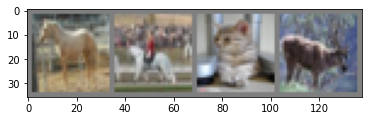

horse horse   cat  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# fixme:展示一些图片
def showImage(img):
    """
    :param img: tensor
    """
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img,(1,2,0)))
    plt.show()

# 随机得到一些训练图片
data_iter = iter(trainloader)
images, labels = data_iter.next()

# 展示图片
showImage(torchvision.utils.make_grid(images))
#print(len(images[0]))
#print(len(torchvision.utils.make_grid(images)[0]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 定义一个卷积神经网络

In [6]:
class Net(nn.Module):
    # fixme:网路初始化
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5) # 输入channel为3，输出channel为6，卷积核大小为5×5
        self.pool = nn.MaxPool2d(2,2) # 2×2的池化层
        self.conv2 = nn.Conv2d(6,16,5) # 输入channel为6，输出channel为16，卷积核大小为5×5
        self.fc1 = nn.Linear(16*5*5,120) # 输入16*5*5，输出为120
        self.fc2 = nn.Linear(120,84) # 输入为120，输出为84
        self.fc3 = nn.Linear(84,10) # 输入为84，输出为10
    # fixme:前向传播
    def forward(self,x):
        # 第一个卷积层
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # 第二个卷积层
        x=  self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # 将特征变换成 x,400的维度
        x = x.view(-1,16*5*5)
        # 全连接层
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 定义损失函数
这里定义了一个损失函数和优化器，使用的是分类交叉熵Cross-Entropy组我诶损失函数，随机梯度下降作为优化器。

In [7]:
import torch.optim as optim

net = Net() # 创建网络实例

criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 设置优化器使用SGD，学习速率和动量分别自己设计

### 训练网络
训练网络的话，只需要在数据迭代器上循环传递给网络和优化器输入即可。

In [8]:
for epoch in range(2): # 循环代数
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # 枚举数据加载器 一个batch_size=4
        images, labels = data # 因为batch_size=4，因此这里一次训练的数据数量为4
        # 将所有参数的梯度设置为0
        optimizer.zero_grad()
        # 前向传播
        predictions = net(images)
        # 计算loss
        loss = criterion(predictions, labels)
        loss.backward() # loss反向传播
        # 优化器对参数进行调整
        optimizer.step()
        
        # 打印状态
        running_loss += loss.item() # 获得loss当前值
        if i % 20000 == 1999: # 每2000个batch打印一次
            print('[%d, %5d] loss: %.3f' % (epoch+1,i+1,running_loss / 20000))
            running_loss = 0.0

print('训练完成!')

[1,  2000] loss: 0.219
[2,  2000] loss: 0.139
训练完成!


In [9]:
predictions = net(images)
# print(predictions)
_, index = predictions.max(1)
print('预测结果为:', ' '.join('%5s' % classes[index[j]] for j in range(4)))

预测结果为:  ship   cat airplane  ship


根据上述预测结果可以看出来，这个网络表现还是可以的，下面看一下在整个测试数据集上的表现。

In [18]:
correct = 0 # 正确率
total = 0 # 样本总数
with torch.no_grad(): # 不需要trick梯度了
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
print('准确率为:' + format(correct/total,'.2f'))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torchvision/datasets/cifar.py", line 113, in __getitem__
    img = self.transform(img)
TypeError: 'module' object is not callable
